# Prerequisites

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Circle
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
data_dir = "../data"
val_img_dir = f"{data_dir}/val_images"
model_dir = "../models"

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
f"Using device: {device}"

'Using device: cuda'

# Dataset class

In [3]:
class HWSet(Dataset):
    """Dataset class for the Husky vs. Wolf dataset."""

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.val_img_dir = f"{self.data_dir}/val_images"

        all_labels = np.loadtxt(
            f"{self.data_dir}/ILSVRC2012_validation_ground_truth.txt"
        ).astype(int)
        all_img_files = os.listdir(self.val_img_dir)

        self.class_indices = []
        for idx, name in ((3, "siberian husky"), (205, "grey wolf")):
            self.class_indices.append(np.where(all_labels == idx)[0])

        self.labels = []
        for label, indices in enumerate(self.class_indices):
            self.labels = self.labels + indices.size * [label]
        self.labels = np.array(self.labels)

        self.imgs = [
            all_img_files[idx] for indices in self.class_indices for idx in indices
        ]

    def __len__(self):
        return self.labels.size

    def __getitem__(self, item):
        img = Image.open(f"{val_img_dir}/{self.imgs[item]}")

        if self.transform is not None:
            img = self.transform(img)

        return (img, self.labels[item])


transform = transforms.Compose(
    [
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
normalize_inv = transforms.Compose(
    [
        transforms.Normalize(
            mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)
        ),
        transforms.Normalize(mean=(-0.485, -0.456, -0.406), std=(1.0, 1.0, 1.0)),
    ]
)  # For visualization purposes.

# Segment Anything Model (SAM)

In [4]:
# Model checkpoints
checkpoints = os.listdir(f"{model_dir}/sam")
checkpoints

['sam_vit_b_01ec64.pth', 'sam_vit_h_4b8939.pth', 'sam_vit_l_0b3195.pth']

In [5]:
# Choose a checkpoint
# H: Huge, L: Large, B: base <=> H > L > B
checkpoint = checkpoints[2]
model_type = checkpoint.split("_")
model_type = model_type[1] + "_" + model_type[2]
assert model_type in checkpoint
checkpoint = f"{model_dir}/sam/{checkpoint}"
checkpoint, model_type

('../models/sam/sam_vit_l_0b3195.pth', 'vit_l')

In [6]:
# Load model
sam = sam_model_registry[model_type](checkpoint=checkpoint)
# sam.to(device)
predictor = SamPredictor(sam)

# Unit test

In [7]:
dset = HWSet(data_dir, transform=transforms.Resize(256, antialias=True))
# dset = HWSet(data_dir, transform=None)

(341, 256)


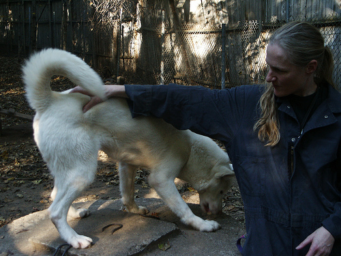

In [8]:
img, label = dset[0]
print(img.size)
img

In [9]:
%%time
predictor.set_image(np.array(img))

CPU times: total: 2min 29s
Wall time: 1min 38s


In [10]:
masks, quality, _ = predictor.predict(
    point_coords=np.array([[30, 64]]), point_labels=np.array([1])
)

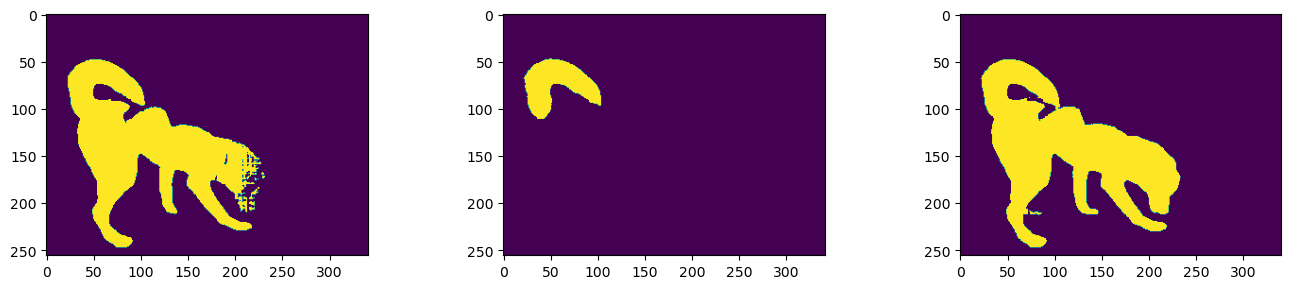

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)
for mask, ax in zip(masks, axs):
    ax.imshow(mask)

# Interactive segmentation

In [12]:
# %matplotlib qt
# def plotimg(img, **kwargs):
#     fig, ax = plt.subplots(1, 1, **kwargs)
#     ax.imshow(img)
#     return fig, ax

# def points2mask(img, predictor, **kwargs):
#     print('Press MMB or escape to close')
#     fig, ax = plotimg(img, **kwargs)
#     plt.get_current_fig_manager().window.showMaximized()
#     points = []
#     point_labels = []
#     current_label = 1
#     while plt.fignum_exists(fig.number):
#         point = plt.ginput()
#         if not len(point):
#             plt.close()
#             return
#         point = np.array(point).T
#         points.append(point.T)
#         point_labels.append(1)
#         masks, quality, _ = predictor.predict(point_coords=np.vstack(points), point_labels=point_labels)
#         mask = masks[0].astype(float)
#         ax.scatter(*point, marker='x', s=15, c='blue')
#         ax.imshow(img)
#         ax.imshow(mask, alpha=mask*0.2, cmap='bwr')
#         fig.canvas.draw()

In [13]:
# points2mask(img, predictor)

In [14]:
# https://github.com/fsemerar/segment-anything-gui/blob/main/segment_anything_gui/gui.py
class Segmenter:
    def __init__(self, img, sam, device="cpu"):
        self.img = img
        self.min_mask_region_area = 500

        # self.sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
        self.sam = sam
        self.sam.to(device)
        self.predictor = SamPredictor(self.sam)

        print("Creating image embeddings ... ", end="")
        self.predictor.set_image(self.img)
        print("Done")

        self.color_set = set()
        self.current_color = self.pick_color()
        self.add_xs, self.add_ys, self.rem_xs, self.rem_ys, self.trace = (
            [],
            [],
            [],
            [],
            [],
        )

        self.fig, self.ax = plt.subplots(
            figsize=(
                10 * (self.img.shape[1] / max(self.img.shape)),
                10 * (self.img.shape[0] / max(self.img.shape)),
            )
        )
        self.fig.suptitle(f"Segment Anything GUI", fontsize=16)
        self.ax.set_title("Press 'h' to show/hide commands.", fontsize=10)
        self.im = self.ax.imshow(self.img)
        self.ax.autoscale(False)
        self.label = 1
        (self.add_plot,) = self.ax.plot(
            [], [], "o", markerfacecolor="green", markeredgecolor="black", markersize=5
        )
        (self.rem_plot,) = self.ax.plot(
            [], [], "x", markerfacecolor="red", markeredgecolor="red", markersize=5
        )
        self.mask_data = np.zeros(
            (self.img.shape[0], self.img.shape[1], 4), dtype=np.uint8
        )
        for i in range(3):
            self.mask_data[:, :, i] = self.current_color[i]
        self.mask_plot = self.ax.imshow(self.mask_data)
        self.prev_mask_data = np.zeros(
            (self.img.shape[0], self.img.shape[1], 4), dtype=np.uint8
        )
        self.prev_mask_plot = self.ax.imshow(self.prev_mask_data)
        (self.contour_plot,) = self.ax.plot([], [], color="black")
        self.fig.canvas.mpl_connect("button_press_event", self._on_click)
        self.fig.canvas.mpl_connect("key_press_event", self._on_key)

        self.show_help_text = False
        self.help_text = plt.text(
            0.5,
            0.5,
            "",
            horizontalalignment="center",
            verticalalignment="center",
            transform=self.ax.transAxes,
        )
        self.opacity = 120  # out of 255
        self.global_masks = np.zeros(
            (self.img.shape[0], self.img.shape[1]), dtype=np.uint8
        )
        self.last_mask = np.zeros(
            (self.img.shape[0], self.img.shape[1]), dtype=bool
        )  # to undo
        self.full_legend = []
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    def save_annotation(self, labels_file_outpath):
        dir_path = os.path.split(labels_file_outpath)[0]
        if dir_path != "" and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        cv2.imwrite(labels_file_outpath, self.global_masks)
        print(f"Saved annotation at {labels_file_outpath}")

    def pick_color(self):
        while True:
            color = tuple(np.random.randint(low=0, high=255, size=3).tolist())
            if color not in self.color_set:
                self.color_set.add(color)
                return color

    def _on_key(self, event):
        if event.key == "z":
            self.undo()

        elif event.key == "enter":
            self.new_tow()

        elif event.key == "escape":  # save for notebooks
            plt.close(self.fig)

        elif event.key == "h":
            if not self.show_help_text:
                self.help_text.set_text(
                    "• 'left click': select a point inside object to label\n"
                    "• 'right click': select a point to exclude from label\n"
                    "• 'enter': confirm current label and create new\n"
                    "• 'z': undo point\n"
                    "• 'esc': close and save"
                )
                self.help_text.set_bbox(
                    dict(facecolor="white", alpha=1, edgecolor="black")
                )
                self.show_help_text = True
            else:
                self.help_text.set_text("")
                self.show_help_text = False
            self.fig.canvas.draw()

    def _on_click(self, event):
        if event.inaxes != self.ax and (event.button in [1, 3]):
            return
        x = int(np.round(event.xdata))
        y = int(np.round(event.ydata))

        if event.button == 1:  # left click
            self.trace.append(True)
            self.add_xs.append(x)
            self.add_ys.append(y)
            self.show_points(self.add_plot, self.add_xs, self.add_ys)

        else:  # right click
            self.trace.append(False)
            self.rem_xs.append(x)
            self.rem_ys.append(y)
            self.show_points(self.rem_plot, self.rem_xs, self.rem_ys)

        self.get_mask()

    def show_points(self, plot, xs, ys):
        plot.set_data(xs, ys)
        self.fig.canvas.draw()

    def clear_mask(self):
        self.contour_plot.set_data([], [])
        self.mask_data.fill(0)
        self.mask_plot.set_data(self.mask_data)
        self.fig.canvas.draw()

    def get_mask(self):
        mask, _, _ = self.predictor.predict(
            point_coords=np.array(
                list(zip(self.add_xs, self.add_ys))
                + list(zip(self.rem_xs, self.rem_ys))
            ),
            point_labels=np.array([1] * len(self.add_xs) + [0] * len(self.rem_xs)),
            multimask_output=False,
        )
        mask = mask[0].astype(np.uint8)

        mask[self.global_masks > 0] = 0
        mask = self.remove_small_regions(mask, self.min_mask_region_area, "holes")
        mask = self.remove_small_regions(mask, self.min_mask_region_area, "islands")

        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
        )
        xs, ys = [], []
        for contour in contours:  # nan to disconnect contours
            xs.extend(contour[:, 0, 0].tolist() + [np.nan])
            ys.extend(contour[:, 0, 1].tolist() + [np.nan])
        self.contour_plot.set_data(xs, ys)

        self.mask_data[:, :, 3] = mask * self.opacity
        self.mask_plot.set_data(self.mask_data)
        self.fig.canvas.draw()

    def undo(self):
        if len(self.trace) == 0:  # undo last mask
            self.global_masks[self.last_mask] = 0
            self.prev_mask_data[:, :, 3][self.last_mask] = 0
            self.prev_mask_plot.set_data(self.prev_mask_data)
            self.label -= 1
            self.full_legend.pop()
            self.ax.legend(
                handles=self.full_legend,
                loc="center left",
                bbox_to_anchor=(1, 0.5),
                ncol=2,
            )
            self.clear_mask()

        else:  # undo last point
            if self.trace[-1]:
                self.add_xs = self.add_xs[:-1]
                self.add_ys = self.add_ys[:-1]
                self.show_points(self.add_plot, self.add_xs, self.add_ys)
            else:
                self.rem_xs = self.rem_xs[:-1]
                self.rem_ys = self.rem_ys[:-1]
                self.show_points(self.rem_plot, self.rem_xs, self.rem_ys)

            self.trace.pop()

            if len(self.trace) != 0:
                self.get_mask()
            else:
                self.clear_mask()

    def new_tow(self):
        # clear points
        self.add_xs, self.add_ys, self.rem_xs, self.rem_ys, self.trace = (
            [],
            [],
            [],
            [],
            [],
        )
        self.show_points(self.add_plot, self.add_xs, self.add_ys)
        self.show_points(self.rem_plot, self.rem_xs, self.rem_ys)

        mask = self.mask_data[:, :, 3] > 0
        self.global_masks[mask] = self.label
        self.last_mask = mask.copy()

        self.prev_mask_data[:, :, :3][mask] = self.current_color
        self.prev_mask_data[:, :, 3][mask] = 255
        self.prev_mask_plot.set_data(self.prev_mask_data)

        self.full_legend.append(
            Circle(1, color=np.array(self.current_color) / 255, label=f"{self.label}")
        )
        self.ax.legend(
            handles=self.full_legend, loc="center left", bbox_to_anchor=(1, 0.5), ncol=2
        )

        self.current_color = self.pick_color()
        self.label += 1

        for i in range(3):
            self.mask_data[:, :, i] = self.current_color[i]
        self.clear_mask()

    @staticmethod
    def remove_small_regions(mask, area_thresh, mode):
        """Function from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/utils/amg.py"""
        assert mode in ["holes", "islands"]
        correct_holes = mode == "holes"
        working_mask = (correct_holes ^ mask).astype(np.uint8)
        n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
        sizes = stats[:, -1][1:]  # Row 0 is background label
        small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
        if len(small_regions) == 0:
            return mask
        fill_labels = [0] + small_regions
        if not correct_holes:
            fill_labels = [i for i in range(n_labels) if i not in fill_labels]
            # If every region is below threshold, keep largest
            if len(fill_labels) == 0:
                fill_labels = [int(np.argmax(sizes)) + 1]
        mask = np.isin(regions, fill_labels)
        return mask

In [15]:
%matplotlib qt
segmenter = Segmenter(np.array(img), sam)
plt.show(block=True);

Creating image embeddings ... Done
